In [1]:
!pip install yfinance statsmodels matplotlib scikit-learn


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error


  Obtaining dependency information for yfinance from https://files.pythonhosted.org/packages/c5/98/6fd94db428a9670d638d4469cedfea51671de0126b8f50de1b06e2245c97/yfinance-0.2.50-py2.py3-none-any.whl.metadata
  Obtaining dependency information for multitasking>=0.0.7 from https://files.pythonhosted.org/packages/3e/8a/bb3160e76e844db9e69a413f055818969c8acade64e1a9ac5ce9dfdcf6c1/multitasking-0.0.11-py3-none-any.whl.metadata
  Obtaining dependency information for frozendict>=2.3.4 from https://files.pythonhosted.org/packages/04/13/d9839089b900fa7b479cce495d62110cddc4bd5630a04d8469916c0e79c5/frozendict-2.4.6-py311-none-any.whl.metadata
     ---------------------------------------- 0.0/948.2 kB ? eta -:--:--
     ---------------------------------------- 10.2/948.2 kB ? eta -:--:--
     - ----------------------------------- 41.0/948.2 kB 393.8 kB/s eta 0:00:03
     --- --------------------------------- 92.2/948.2 kB 581.0 kB/s eta 0:00:02
     ---- ------------------------------- 122.9/948.2 kB

# Загрузка данных Ethereum (ETH)

[*********************100%***********************]  1 of 1 completed


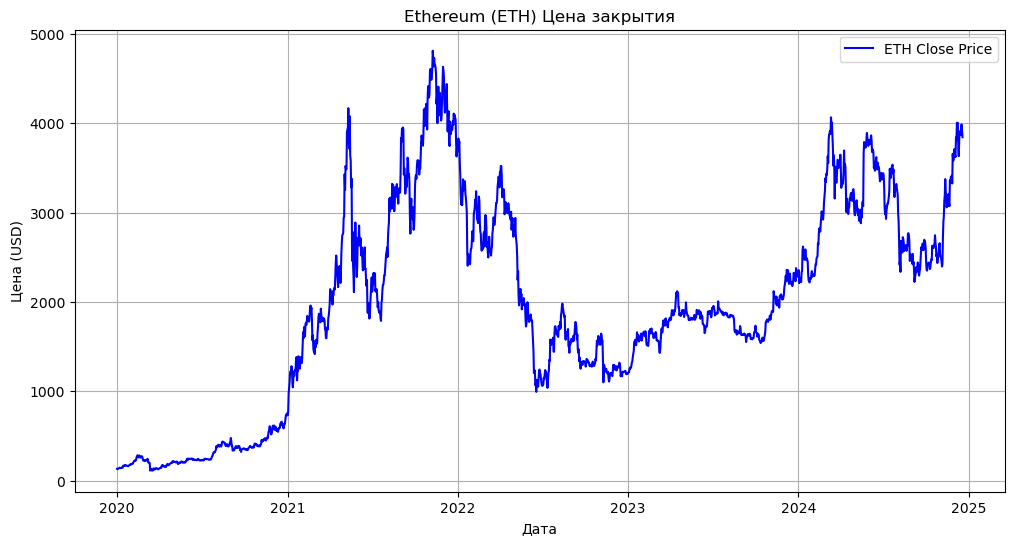

In [3]:
# Загрузка данных о ценах Ethereum (ETH) с Yahoo Finance
eth = yf.download('ETH-USD', start='2020-01-01', end='2024-12-31')
eth_close = eth['Close']  # Берем только цены закрытия

# Визуализация исходного временного ряда
plt.figure(figsize=(12, 6))
plt.plot(eth_close, label='ETH Close Price', color='blue')
plt.title('Ethereum (ETH) Цена закрытия')
plt.xlabel('Дата')
plt.ylabel('Цена (USD)')
plt.legend()
plt.grid()
plt.show()


# Декомпозиция временного ряда

Ticker
ETH-USD    1
dtype: int64


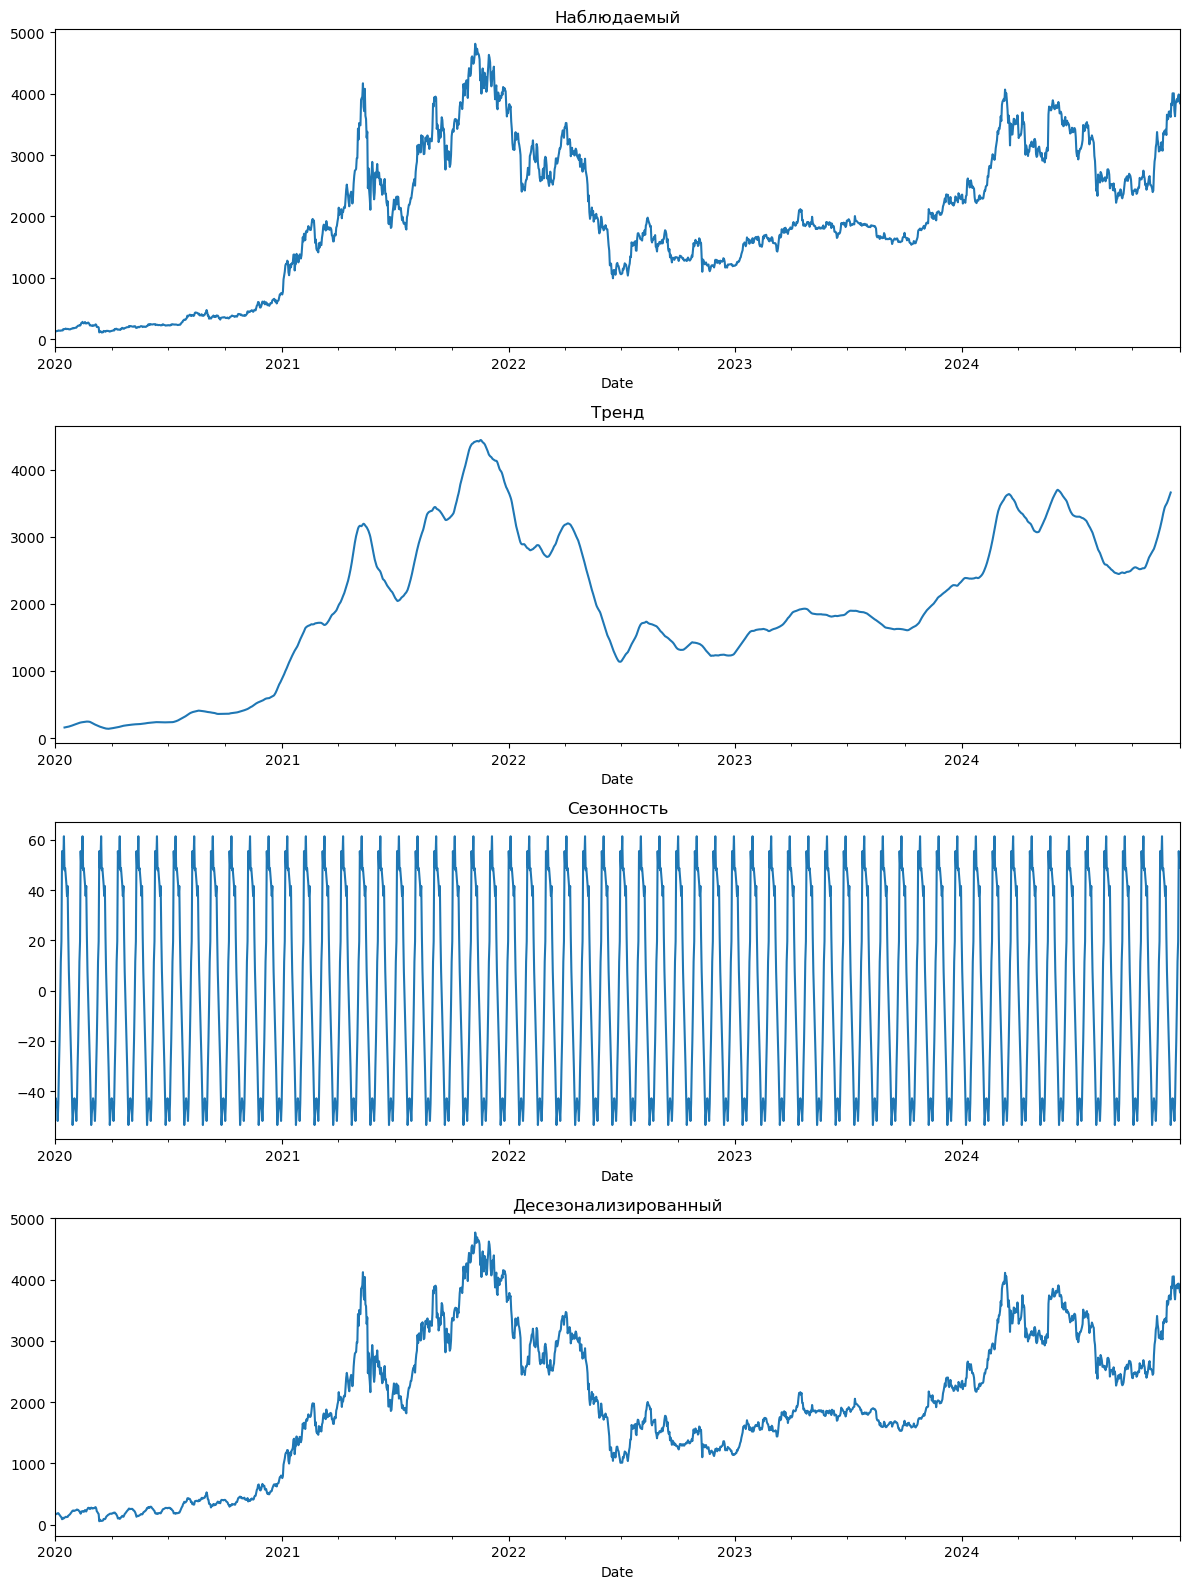

In [37]:
# Проверка на наличие пропусков
print(eth_close.isna().sum())

# Заполнение пропусков с помощью линейной интерполяции
eth_close = eth_close.interpolate(method='linear')

# Декомпозиция временного ряда Ethereum после обработки пропусков
decomposition = seasonal_decompose(eth_close, model='additive', period=30)

# Отображение графиков
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(12, 16))

decomposition.observed.plot(ax=ax1)
ax1.set_title('Наблюдаемый')

decomposition.trend.plot(ax=ax2)
ax2.set_title('Тренд')

decomposition.seasonal.plot(ax=ax3)
ax3.set_title('Сезонность')

deseasonal = decomposition.observed - decomposition.seasonal
deseasonal.plot(ax=ax4)
ax4.set_title('Десезонализированный')

plt.tight_layout()
plt.show()


In [38]:
def predict_ema(data, periods=5):
    ema = data.ewm(span=30, adjust=False).mean()  # EMA с периодом 30
    last_ema = ema.iloc[-1]  # Последнее значение EMA
    
    last_date = data.index[-1]
    future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=periods)
    
    # Рассчитываем темп роста, если есть хотя бы два значения для EMA
    if len(ema) > 1:
        growth_rate = (ema.iloc[-1] / ema.iloc[-2]) - 1
    else:
        growth_rate = 0
    
    # Прогнозируем значения на будущее, используя темп роста
    future_ema = [last_ema * (1 + growth_rate)**i for i in range(1, periods + 1)]
    
    return future_dates, future_ema

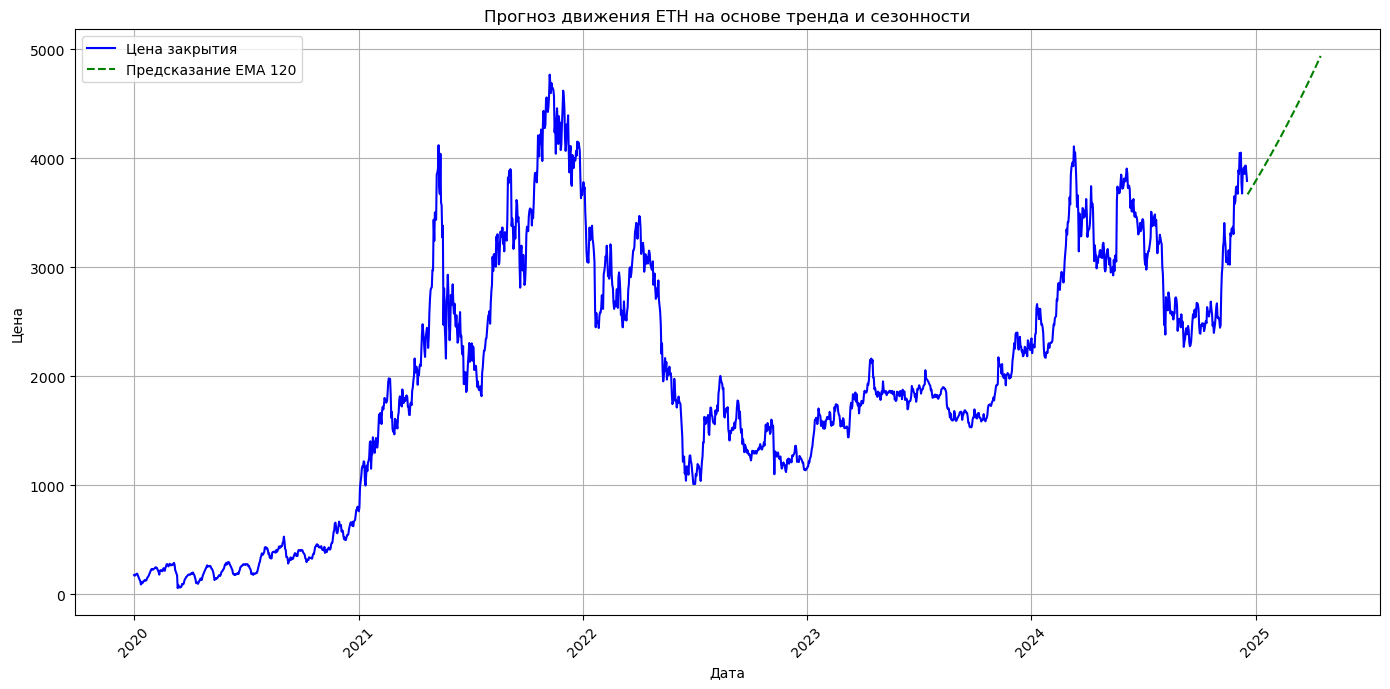

In [39]:
# Прогнозирование на основе десезонализированных данных
future_dates, future_ema = predict_ema(deseasonal, 120)

# Отображение графика
plt.figure(figsize=(14, 7))
plt.plot(deseasonal.index, deseasonal.values, label='Цена закрытия', color='blue')
plt.plot(future_dates, future_ema, label='Предсказание EMA 120', color='green', linestyle='dashed')
plt.xlabel('Дата')
plt.ylabel('Цена')
plt.title('Прогноз движения ETH на основе тренда и сезонности')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Оценим качество прогноза, используя метрики MAE и RMSE

In [43]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Загрузка данных для прогнозирования (например, для ETH)
eth_future = yf.download('ETH-USD', start='2024-01-01', end='2024-06-17')
eth_future_close = eth_future['Close']  # Берем только цены закрытия

# Оценка качества прогноза
mae = mean_absolute_error(eth_future_close[:len(future_ema)], future_ema)
rmse = np.sqrt(mean_squared_error(eth_future_close[:len(future_ema)], future_ema))

# Вывод метрик
print(f"MAE: {round(mae, 2)}, RMSE: {round(rmse, 2)}")

[*********************100%***********************]  1 of 1 completed

MAE: 1271.79, RMSE: 1324.07


мы видим, что модель пока не дает достаточно точных прогнозов для предсказания цен Ethereum, вообще криптовалюта вещь непредсказуемая 

Проведём тест на стационарность

In [44]:
from statsmodels.tsa.stattools import adfuller

def adf_test(series):
    result = adfuller(series, autolag='AIC')
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    print('Critical Values:')
    for key, value in result[4].items():
        print(f'\t{key}: {value}')

# Применим ADF тест к Ethereum
adf_test(eth_close)


ADF Statistic: -1.7605982815484393
p-value: 0.40019145265733685
Critical Values:
	1%: -3.4339740253219566
	5%: -2.863140805408186
	10%: -2.5676222161097058


Так как p-value > 0.05, то ряд нестационарный

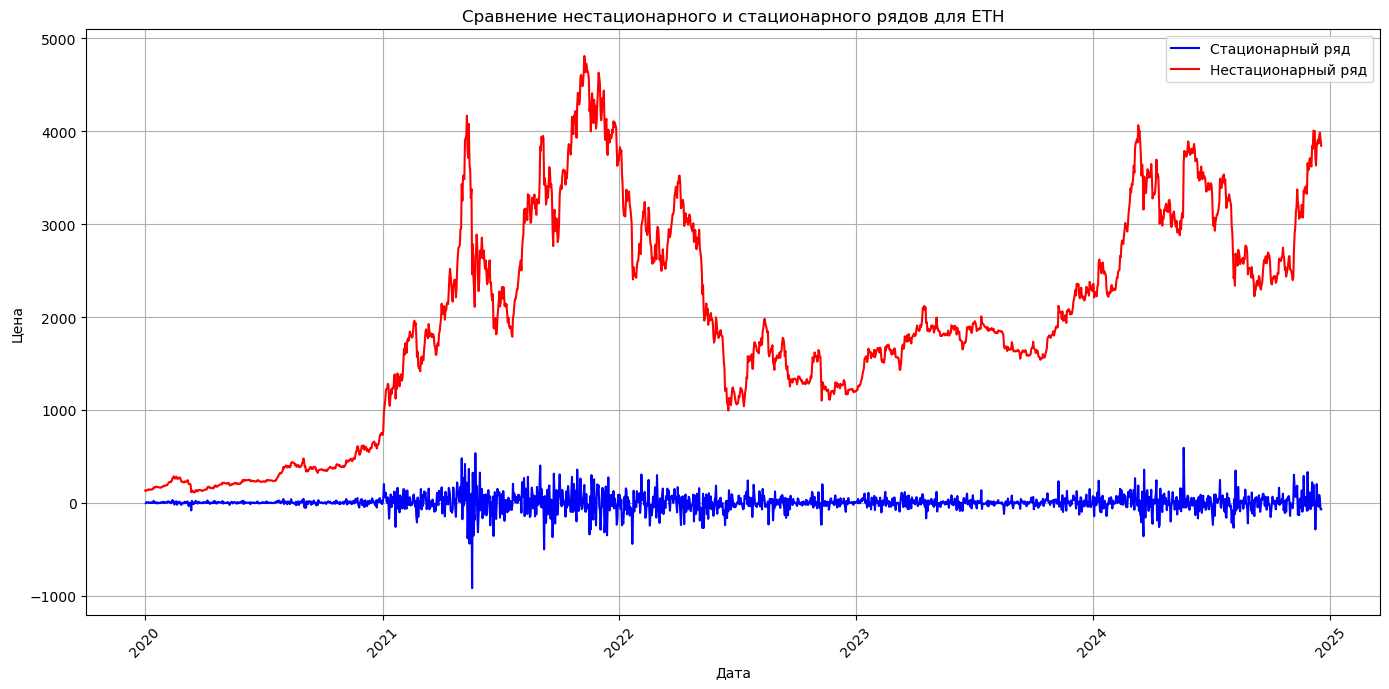

In [46]:
# Делаем разницу (дифференцируем) для ETH
differenced_eth = eth_close.diff().dropna()

# Строим график
plt.figure(figsize=(14, 7))
plt.plot(differenced_eth.index, differenced_eth.values, label='Стационарный ряд', color='blue')  # Стационарный
plt.plot(eth_close.index, eth_close.values, label='Нестационарный ряд', color='red')  # Нестационарный
plt.xlabel('Дата')
plt.ylabel('Цена')
plt.title('Сравнение нестационарного и стационарного рядов для ETH')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [48]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error

def evaluate_arima_model_eth(X, arima_order):
    # Разделение на обучающую и тестовую выборки
    train_size = int(len(X) * 0.8)
    train, test = X[:train_size], X[train_size:]
    
    # Обучение модели ARIMA
    model = ARIMA(train, order=arima_order, trend='ct')
    model_fit = model.fit()
    
    # Прогнозирование
    forecast = model_fit.forecast(steps=len(test))
    
    # Оценка качества прогноза
    mae = mean_absolute_error(test, forecast)
    rmse = np.sqrt(mean_squared_error(test, forecast))
    
    return mae, rmse


AR Модель

In [49]:
p_values = range(0, 10)
d_values = [0]
q_values = [0]

# Убедитесь, что индекс временного ряда имеет правильную частоту
deseasonal.index = pd.DatetimeIndex(deseasonal.index.values, freq=deseasonal.index.inferred_freq)

best_score_ar, best_cfg_ar = float("inf"), None
for p in p_values:
    for d in d_values:
        for q in q_values:
            order = (p, d, q)
            try:
                # Оценка модели ARIMA
                mae, rmse = evaluate_arima_model_eth(deseasonal, order)
                if mae < best_score_ar:
                    best_score_ar, best_cfg_ar = mae, order
                print(f'AR{order} MAE={mae:.3f} RMSE={rmse:.3f}')
            except Exception as e:
                print(f"Ошибка для модели AR{order}: {e}")
                continue

# Выводим лучшую модель
print(f'Лучшая модель AR{best_cfg_ar} MAE={best_score_ar:.3f}')


AR(0, 0, 0) MAE=522.249 RMSE=640.079
AR(1, 0, 0) MAE=581.203 RMSE=737.183
AR(2, 0, 0) MAE=577.418 RMSE=729.384
AR(3, 0, 0) MAE=577.138 RMSE=728.948
AR(4, 0, 0) MAE=576.034 RMSE=727.078
AR(5, 0, 0) MAE=587.650 RMSE=746.955
AR(6, 0, 0) MAE=576.697 RMSE=728.657
AR(7, 0, 0) MAE=589.644 RMSE=749.965
AR(8, 0, 0) MAE=590.956 RMSE=751.977
AR(9, 0, 0) MAE=592.942 RMSE=755.205
Лучшая модель AR(0, 0, 0) MAE=522.249


MA модель

In [53]:
p_values = [0]
d_values = [0]
q_values = range(0, 10)

deseasonal.index = pd.DatetimeIndex(deseasonal.index.values, freq=deseasonal.index.inferred_freq)

best_score_ma, best_cfg_ma = float("inf"), None
for p in p_values:
    for d in d_values:
        for q in q_values:
            order = (p, d, q)
            try:
                mae, rmse = evaluate_arima_model(deseasonal, order)
                if mae < best_score_ma:
                    best_score_ma, best_cfg_ma = mae, order
                print(f'MA{order} MAE={mae:.3f} RMSE={rmse:.3f}')
            except:
                continue

print(f'Лучшая модель MA{best_cfg_ma} MAE={best_score_ma:.3f}')

MA(0, 0, 0) MAE=1300.195 RMSE=1401.184
MA(0, 0, 1) MAE=1299.733 RMSE=1401.070
MA(0, 0, 2) MAE=1298.653 RMSE=1400.784


C:\Users\User\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\User\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


MA(0, 0, 3) MAE=1297.761 RMSE=1400.592


C:\Users\User\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\User\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


MA(0, 0, 4) MAE=1296.355 RMSE=1400.275


C:\Users\User\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\User\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


MA(0, 0, 5) MAE=1295.660 RMSE=1400.147
MA(0, 0, 6) MAE=1296.499 RMSE=1400.200


C:\Users\User\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\User\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


MA(0, 0, 7) MAE=1300.159 RMSE=1401.967


C:\Users\User\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


MA(0, 0, 8) MAE=1295.893 RMSE=1400.149


C:\Users\User\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


MA(0, 0, 9) MAE=1293.631 RMSE=1399.457
Лучшая модель MA(0, 0, 9) MAE=1293.631


ARMA модель

In [63]:
import warnings
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm

# Отключаем все предупреждения
warnings.filterwarnings("ignore")

# Функция для оценки модели ARIMA
def evaluate_arima_model(X, arima_order):
    # Разделение на обучающую и тестовую выборки
    train_size = int(len(X) * 0.8)
    train, test = X[:train_size], X[train_size:]
    
    # Обучение модели
    model = ARIMA(train, order=arima_order)
    model_fit = model.fit()
    
    # Прогноз
    forecast = model_fit.forecast(steps=len(test))
    
    # Оценка качества прогноза
    mae = mean_absolute_error(test, forecast)
    rmse = np.sqrt(mean_squared_error(test, forecast))
    
    return mae, rmse

# Параметры для подбора модели
p_values = range(0, 5)
d_values = [0]
q_values = range(0, 5)

# Обновление индекса временного ряда
deseasonal.index = pd.DatetimeIndex(deseasonal.index.values, freq=deseasonal.index.inferred_freq)

best_score_arma, best_cfg_arma = float("inf"), None
for p in p_values:
    for d in d_values:
        for q in q_values:
            order = (p, d, q)
            try:
                mae, rmse = evaluate_arima_model(deseasonal, order)
                if mae < best_score_arma:
                    best_score_arma, best_cfg_arma = mae, order
                print(f'ARMA{order} MAE={mae:.3f} RMSE={rmse:.3f}')
            except:
                continue

print(f'Лучшая модель ARMA{best_cfg_arma} MAE={best_score_arma:.3f}')

ARMA(0, 0, 0) MAE=1300.195 RMSE=1401.184
ARMA(0, 0, 1) MAE=1299.733 RMSE=1401.070
ARMA(0, 0, 2) MAE=1298.653 RMSE=1400.784
ARMA(0, 0, 3) MAE=1297.761 RMSE=1400.592
ARMA(0, 0, 4) MAE=1296.355 RMSE=1400.275
ARMA(1, 0, 0) MAE=1002.413 RMSE=1141.892
ARMA(1, 0, 1) MAE=1008.581 RMSE=1147.612
ARMA(1, 0, 2) MAE=1011.833 RMSE=1150.738
ARMA(1, 0, 3) MAE=1008.841 RMSE=1147.864
ARMA(1, 0, 4) MAE=1017.364 RMSE=1155.982
ARMA(2, 0, 0) MAE=981.508 RMSE=1121.894
ARMA(2, 0, 1) MAE=980.390 RMSE=1120.837
ARMA(2, 0, 2) MAE=982.906 RMSE=1123.302
ARMA(2, 0, 3) MAE=978.398 RMSE=1119.017
ARMA(2, 0, 4) MAE=999.090 RMSE=1138.753
ARMA(3, 0, 0) MAE=982.740 RMSE=1123.075
ARMA(3, 0, 1) MAE=983.802 RMSE=1124.159
ARMA(3, 0, 2) MAE=998.323 RMSE=1138.449
ARMA(3, 0, 3) MAE=975.136 RMSE=1115.882
ARMA(3, 0, 4) MAE=993.079 RMSE=1133.079
ARMA(4, 0, 0) MAE=991.018 RMSE=1130.912
ARMA(4, 0, 1) MAE=977.179 RMSE=1117.848
ARMA(4, 0, 2) MAE=974.181 RMSE=1114.997
ARMA(4, 0, 3) MAE=984.988 RMSE=1125.269
ARMA(4, 0, 4) MAE=993.504 RMSE

ARIMA модель

In [66]:
# Задаем параметры p, d, q для поиска лучшей модели ARIMA
p_values = range(0, 3)  # Параметры p
d_values = range(0, 3)  # Параметры d
q_values = range(0, 3)  # Параметры q

best_score_arima, best_cfg_arima = float("inf"), None

# Перебор возможных сочетаний параметров ARIMA
for p in p_values:
    for d in d_values:
        for q in q_values:
            order = (p, d, q)
            try:
                mae, rmse = evaluate_arima_model(eth_close, order)
                if mae < best_score_arima:
                    best_score_arima, best_cfg_arima = mae, order
                print(f'ARIMA{order} MAE={mae:.3f} RMSE={rmse:.3f}')
            except:
                continue

print(f'Лучшая модель ARIMA{best_cfg_arima} MAE={best_score_arima:.3f}')

ARIMA(0, 0, 0) MAE=1300.832 RMSE=1401.599
ARIMA(0, 0, 1) MAE=1300.358 RMSE=1401.463
ARIMA(0, 0, 2) MAE=1299.241 RMSE=1401.129
ARIMA(0, 1, 0) MAE=773.944 RMSE=932.993
ARIMA(0, 1, 1) MAE=776.586 RMSE=935.259
ARIMA(0, 1, 2) MAE=775.508 RMSE=934.332
ARIMA(0, 2, 0) MAE=6075.724 RMSE=7230.358
ARIMA(0, 2, 1) MAE=595.642 RMSE=757.692
ARIMA(0, 2, 2) MAE=584.173 RMSE=740.952
ARIMA(1, 0, 0) MAE=993.333 RMSE=1134.454
ARIMA(1, 0, 1) MAE=973.591 RMSE=1115.523
ARIMA(1, 0, 2) MAE=1008.352 RMSE=1148.647
ARIMA(1, 1, 0) MAE=776.400 RMSE=935.099
ARIMA(1, 1, 1) MAE=776.049 RMSE=934.798
ARIMA(1, 1, 2) MAE=774.679 RMSE=933.623
ARIMA(1, 2, 0) MAE=5205.153 RMSE=6230.516
ARIMA(1, 2, 1) MAE=580.173 RMSE=734.487
ARIMA(1, 2, 2) MAE=578.659 RMSE=732.610
ARIMA(2, 0, 0) MAE=972.225 RMSE=1114.243
ARIMA(2, 0, 1) MAE=992.554 RMSE=1133.597
ARIMA(2, 0, 2) MAE=974.184 RMSE=1116.228
ARIMA(2, 1, 0) MAE=775.721 RMSE=934.516
ARIMA(2, 1, 1) MAE=774.501 RMSE=933.459
ARIMA(2, 1, 2) MAE=774.721 RMSE=933.659
ARIMA(2, 2, 0) MAE=2776

Прогноз

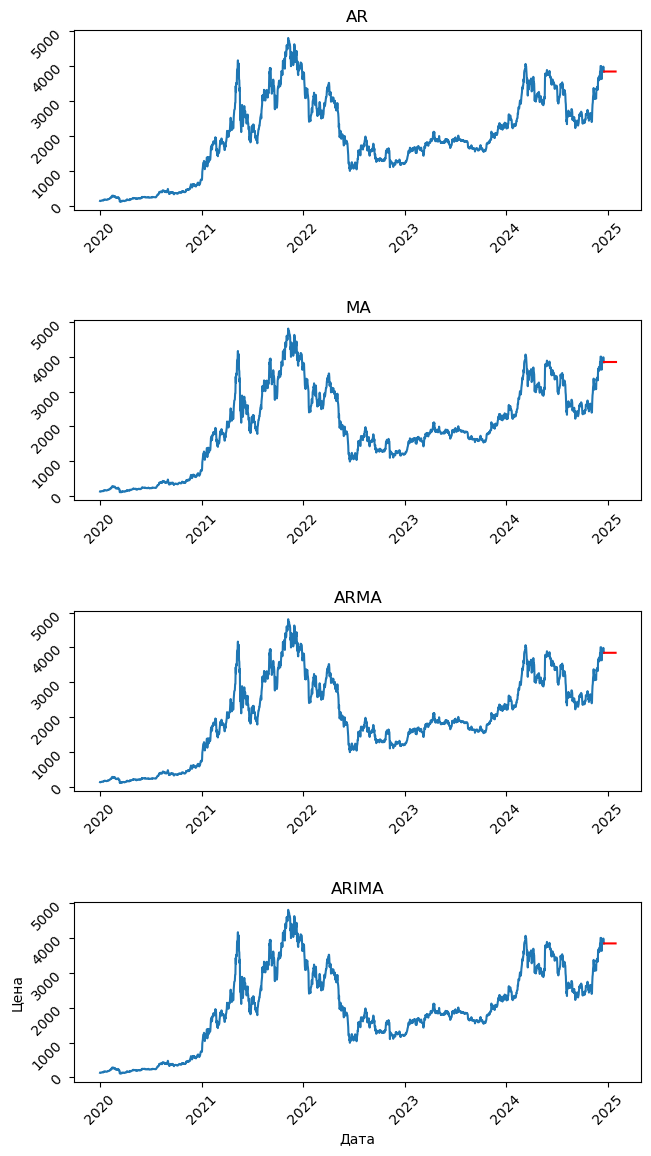

In [67]:
# Предположим, что вы уже определили лучшие параметры для моделей:
best_cfg_ar = (1, 1, 0)    # Пример: AR(1) модель
best_cfg_ma = (0, 1, 1)    # Пример: MA(1) модель
best_cfg_arma = (1, 1, 1)  # Пример: ARMA(1,1) модель
best_cfg_arima = (1, 1, 1) # Пример: ARIMA(1,1,1) модель

# Модели AR, MA, ARMA и ARIMA
model_ar = ARIMA(eth_close, order=best_cfg_ar)
model_ma = ARIMA(eth_close, order=best_cfg_ma)
model_arma = ARIMA(eth_close, order=best_cfg_arma)
model_arima = ARIMA(eth_close, order=best_cfg_arima)

# Обучаем модели
model_fit_ar = model_ar.fit()
model_fit_ma = model_ma.fit()
model_fit_arma = model_arma.fit()
model_fit_arima = model_arima.fit()

# Прогнозируем на 30 шагов вперед
forecast_ar = model_fit_ar.forecast(steps=30)
forecast_ma = model_fit_ma.forecast(steps=30)
forecast_arma = model_fit_arma.forecast(steps=30)
forecast_arima = model_fit_arima.forecast(steps=30)

# Создаем временные индексы для прогнозов
forecast_ar_index = pd.date_range(start=eth_close.index[-1] + pd.Timedelta(days=1), periods=30, freq='B')
forecast_ma_index = pd.date_range(start=eth_close.index[-1] + pd.Timedelta(days=1), periods=30, freq='B')
forecast_arma_index = pd.date_range(start=eth_close.index[-1] + pd.Timedelta(days=1), periods=30, freq='B')
forecast_arima_index = pd.date_range(start=eth_close.index[-1] + pd.Timedelta(days=1), periods=30, freq='B')

# Визуализация прогноза для каждой модели
fig, ax = plt.subplots(4)
fig.tight_layout()
fig.set_figheight(12)

ax[0].plot(eth_close.index, eth_close, label='Исторические данные')
ax[1].plot(eth_close.index, eth_close, label='Исторические данные')
ax[2].plot(eth_close.index, eth_close, label='Исторические данные')
ax[3].plot(eth_close.index, eth_close, label='Исторические данные')

ax[0].plot(forecast_ar_index, forecast_ar, color='red', label='Прогноз AR')
ax[1].plot(forecast_ma_index, forecast_ma, color='red', label='Прогноз MA')
ax[2].plot(forecast_arma_index, forecast_arma, color='red', label='Прогноз ARMA')
ax[3].plot(forecast_arima_index, forecast_arima, color='red', label='Прогноз ARIMA')

ax[0].title.set_text("AR")
ax[1].title.set_text("MA")
ax[2].title.set_text("ARMA")
ax[3].title.set_text("ARIMA")

plt.xlabel('Дата')
plt.ylabel('Цена')
ax[0].tick_params(labelrotation=45)
ax[1].tick_params(labelrotation=45)
ax[2].tick_params(labelrotation=45)
ax[3].tick_params(labelrotation=45)

plt.show()

In [68]:
# Заменим rub_usd_future_30 на последние 30 значений цен Ethereum (ETH)
eth_future_30 = eth_close[-30:]  # Последние 30 значений ETH для вычисления ошибок

# Вычисление метрик ошибок для каждой модели
mae_ar = mean_absolute_error(eth_future_30, forecast_ar)
mae_ma = mean_absolute_error(eth_future_30, forecast_ma)
mae_arma = mean_absolute_error(eth_future_30, forecast_arma)
mae_arima = mean_absolute_error(eth_future_30, forecast_arima)

rmse_ar = np.sqrt(mean_squared_error(eth_future_30, forecast_ar))
rmse_ma = np.sqrt(mean_squared_error(eth_future_30, forecast_ma))
rmse_arma = np.sqrt(mean_squared_error(eth_future_30, forecast_arma))
rmse_arima = np.sqrt(mean_squared_error(eth_future_30, forecast_arima))

mape_ar = np.mean(np.abs((eth_future_30 - forecast_ar) / eth_future_30)) * 100
mape_ma = np.mean(np.abs((eth_future_30 - forecast_ma) / eth_future_30)) * 100
mape_arma = np.mean(np.abs((eth_future_30 - forecast_arma) / eth_future_30)) * 100
mape_arima = np.mean(np.abs((eth_future_30 - forecast_arima) / eth_future_30)) * 100

# Вывод результатов
print("---AR---")
print(f"MAE: {round(mae_ar, 2)}, RMSE: {round(rmse_ar, 2)}, MAPE: {round(mape_ar, 2)}")
print("---MA---")
print(f"MAE: {round(mae_ma, 2)}, RMSE: {round(rmse_ma, 2)}, MAPE: {round(mape_ma, 2)}")
print("---ARMA---")
print(f"MAE: {round(mae_arma, 2)}, RMSE: {round(rmse_arma, 2)}, MAPE: {round(mape_arma, 2)}")
print("---ARIMA---")
print(f"MAE: {round(mae_arima, 2)}, RMSE: {round(rmse_arima, 2)}, MAPE: {round(mape_arima, 2)}")


---AR---
MAE: 238.08, RMSE: 318.04, MAPE: nan
---MA---
MAE: 238.19, RMSE: 318.2, MAPE: nan
---ARMA---
MAE: 237.85, RMSE: 317.74, MAPE: nan
---ARIMA---
MAE: 237.85, RMSE: 317.74, MAPE: nan


Для всех моделей значение MAPE равно nan, что может быть связано с особенностями данных.
Вывод: На основе MAE и RMSE, можно отметить, что модели ARMA и ARIMA показали схожие результаты с минимальными ошибками, что позволяет считать их наилучшими для прогнозирования. Модели AR и MA продемонстрировали немного больше ошибкок по сравнению с ARMA и ARIMA.